In [1]:
import sys, os, copy, re, pathlib
from natsort import natsorted
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
# Delete all plots: 
if False:
    home_p = pathlib.Path('plots/')
    for path in home_p.glob('**/*.pdf'):
        # print(path)
        os.remove(path)

In [4]:
def approx_ratio_stats(a, b):
    # Making a lot of assumptions about normality
    # and no covariance estimate ratio stats:
    # https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error
    # I think this is derived from the first term of a Taylor expansion of the real solution.
    a_mean, a_stdev = a
    b_mean, b_stdev = b
    ratio_mean = a_mean / b_mean
    ratio_stdev = ratio_mean * np.sqrt((a_stdev / a_mean)**2 + (b_stdev / b_mean)**2)
    return((ratio_mean, ratio_stdev))

In [5]:
# Convert row letter to integer,
# for indicating replicates:
letter2rep = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [6]:
# Read sample annotations:
sample_anno = pd.read_excel('sample_annotations.xlsx')
sample_anno

Cell_line                  Folder Plate  Time_first_mes  \
0        HT1080-WT_ATF4-rep           01-04-22_high    p1             2.0   
1        HT1080-WT_ATF4-rep           01-04-22_high    p2             2.0   
2        HT1080-WT_ATF4-rep           01-04-22_high    p3             2.0   
3        HT1080-WT_ATF4-rep           01-04-22_high    p4             2.0   
4        HT1080-WT_ATF4-rep           01-04-22_high    p5             2.0   
..                      ...                     ...   ...             ...   
90  HT1080-WT_ATF4-rep_eGFP  02-15-22_low-eGFP-mean    p2            20.0   
91  HT1080-WT_ATF4-rep_eGFP  02-15-22_low-eGFP-mean    p3            20.0   
92  HT1080-WT_ATF4-rep_ASNS  02-15-22_low-ASNS-mean    p1            20.0   
93  HT1080-WT_ATF4-rep_ASNS  02-15-22_low-ASNS-mean    p2            20.0   
94  HT1080-WT_ATF4-rep_ASNS  02-15-22_low-ASNS-mean    p3            20.0   

    Timepoints  Gradient Unit        Drug Rescue    Col 1 Col 2 Col 3 Col 4  \
0         True     False  NaN     Vehicle    NaN  Vehicle    SM   Asp   Pyr   
1         True     False  NaN    Rotenone    NaN  Vehicle    SM   Asp   Pyr   
2         True     False  NaN   Antimycin    NaN  Vehicle    SM   Asp   Pyr   
3         True     False  NaN  Oligomycin    NaN  Vehicle    SM   Asp   Pyr   
4         True     False  NaN        FCCP    NaN  Vehicle    SM   Asp   Pyr   
..         ...       ...  ...         ...    ...      ...   ...   ...   ...   
90       False     False  NaN    Rotenone    NaN  Vehicle   Asn    SM   Asp   
91       False     False  NaN   Antimycin    NaN  Vehicle   Asn    SM   Asp   
92       False     False  NaN     Vehicle    NaN  Vehicle   Asn    SM   Asp   
93       False     False  NaN    Rotenone    NaN  Vehicle   Asn    SM   Asp   
94       False     False  NaN   Antimycin    NaN  Vehicle   Asn    SM   Asp   

   Col 5 Col 6  
0    NA1   NA2  
1    NA1   NA2  
2    NA1   NA2  
3    NA1   NA2  
4    NA1   NA2  
..   ...   ...  
90   Pyr   aKB  
91   Pyr   aKB  
92   Pyr   aKB  
93   Pyr   aKB  
94   Pyr   aKB  

[95 rows x 15 columns]

# Helper functions

Functions for reading IncuCyte data, merging with sample annotations and normalizing based of Vehicle plate. Also functions for plotting the resulting processed data.

In [7]:
def rp_data(cell_line_folder, date_list):
    # Read data into dataframe:
    data = pd.DataFrame(columns=['Folder', 'Plate', 'Time', 'Drug', 'Rescue', 'Replicate', 'RFP', 'RFP_norm'])
    row_idx = 0
    home_p = pathlib.Path('data/{}'.format(cell_line_folder))
    for path in home_p.glob('*'):
        folder = str(path).split('/')[-1]
        # Require the date to be part of folder name:
        if sum(1 for d in date_list if d in folder) == 0:
            continue
        for fnam in natsorted(home_p.glob('{}/*.txt'.format(folder))):
            plate = str(fnam).split('/')[-1][:-4]
            tmp_df = pd.read_csv(fnam, skiprows=1, sep='\t')

            for time_idx in range(len(tmp_df)):
                elapsed = tmp_df.loc[time_idx, 'Elapsed']
                for colnam, val in zip(tmp_df.columns, tmp_df.loc[time_idx].values):
                    if colnam[0] in 'ABCD' and colnam[1] in '123456':
                        pass
                    else:
                        continue

                    rep = letter2rep[colnam[0]]
                    col = 'Col {}'.format(colnam[1])
                    mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
                    time = elapsed + sample_anno.loc[mask, 'Time_first_mes'].values[0]
                    drug = sample_anno.loc[mask, 'Drug'].values[0]
                    rescue = sample_anno.loc[mask, col].values[0]
                    data_list = [folder, plate, time, drug, rescue, rep, val, 0]
                    data.loc[row_idx, :] = data_list
                    row_idx += 1
    data.RFP = data.RFP.astype(float)
    data.Time = data.Time.astype(float)

    # Normalize to vehicle plate and vehicle/vehicle:
    data['RFP_vec'] = 0
    data['RFP_vec-vec'] = 0
    for folder in set(data['Folder'].values):
        for mix in [True, False]:
            if mix:
                mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] == 'Mix')
                mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Mix') & (data['Rescue'] == 'Vehicle')
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_mix, ]
                df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_mix, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
                data.loc[mask_folder_mix, 'RFP_vec-vec'] = df_b_merged['RFP_vec-merged'].values
            else:
                mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] != 'Mix')
                mask_denom_vec = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle')
                mask_denom_vec_vec = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle') & (data['Rescue'] == 'Vehicle')
                # Extract Vehicle RFP:
                df_vec = data.loc[mask_denom_vec, ['Time', 'RFP']].groupby('Time').mean()
                df_vec_vec = data.loc[mask_denom_vec_vec, ['Time', 'RFP']].groupby('Time').mean()
                # Merge based on time:
                df_b = data.loc[mask_folder_mix, ]
                df_b_merged_vec = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                df_b_merged_vec_vec = df_b.merge(df_vec_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
                # Insert the time matched vehicle RFP into dataframe:
                data.loc[mask_folder_mix, 'RFP_vec'] = df_b_merged_vec['RFP_vec-merged'].values
                data.loc[mask_folder_mix, 'RFP_vec-vec'] = df_b_merged_vec_vec['RFP_vec-merged'].values

    # Normalize based on the average accross the whole vehicle plate:
    data['RFP_norm-VecPlate'] = data['RFP'] / data['RFP_vec']
    # Normalize based on the Vehicle column on the vehicle plate:
    data['RFP_norm-Vec-Vec'] = data['RFP'] / data['RFP_vec-vec']
    
    return(data)

In [8]:
def plot_timecourse(data, folder, drug_list, red, plot_dst, norm):
    for drug in drug_list:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        mask = (data['Folder'] == folder) & (data['Drug'] == drug) & (data['Rescue'] != 'NA1') & (data['Rescue'] != 'NA2')
        if drug != 'Mix':
            hue_list = ['Vehicle', 'Asn', 'SM', 'Asp', 'Pyr', 'aKB']
            hue_obs = list(set(data[mask]['Rescue'].values))
            hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
            hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
            ax1.axvline(x=red['NoMix'], color='r', linestyle='--', zorder=0)
        else:
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
            ax1.axvline(x=red['Mix'], color='r', linestyle='--', zorder=0)
        ax1.set_xlim(0, ax1.get_xlim()[1])
        if norm != 'RFP':
            ax1.set_ylim(0, ax1.get_ylim()[1])
        if norm == 'RFP':
            g1.set_ylabel('RFP (AU)')
        elif 'VecPlate' in norm:
            g1.set_ylabel('RFP (norm. to Vec. plate)')
        else:
            g1.set_ylabel('RFP (norm. to Vec/Vec)')
        g1.set_xlabel('Time after treatment (hours)')
        g1.set_title('{}'.format(drug))
        g1.grid(True, axis='y')
        g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')
        sns.despine()
        fig.tight_layout()
        if norm == 'RFP':
            fig.savefig('{}/{}_{}-timecourse.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')
        else:
            fig.savefig('{}/{}_{}-timecourse_norm.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')

In [9]:
def plot_bars(data, folder, time, norm, title, ext='', y0=False, y1=False):
    fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))
    mask = (data['Folder'] == folder) & (data['Drug'] != 'Mix') & (data['Time'] == time) & (data['Rescue'] != 'NA1') & (data['Rescue'] != 'NA2')
    hue_list = ['Vehicle', 'Asn', 'SM', 'Asp', 'Pyr', 'aKB']
    hue_obs = list(set(data[mask]['Rescue'].values))
    hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
    hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
    g1 = sns.barplot(ax=ax1, data=data[mask], x='Drug', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    ax1.axhline(y=1, color='r', linestyle='--', zorder=0)
    if norm != 'RFP' and not y0:
        ax1.set_ylim(0, ax1.get_ylim()[1])
    elif y0 is not False and y1 is False:
        ax1.set_ylim(y0, ax1.get_ylim()[1])
    elif y0 is not False and y1 is not False:
        ax1.set_ylim(y0, y1)
    if norm == 'RFP':
        g1.set_ylabel('RFP (AU)')
    elif 'VecPlate' in norm:
        g1.set_ylabel('RFP (norm. to Vec. plate)')
    else:
        g1.set_ylabel('RFP (norm. to Vec/Vec)')
    g1.set_xlabel('')
    g1.set_title(title)
    g1.grid(True, axis='y')
    g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')
    #g1.set(yscale="log")
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}-mito-inhib_barplot{}.pdf'.format(plot_dst, folder, ext), bbox_inches='tight')

In [10]:
def plot_bar_Atp(data, fd, td, norm, plot_dst):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
    mask = (data['Drug'] == 'Mix') & (((data['Folder'] == fd['low']) & (data['Time'] == td['low'])) | ((data['Folder'] == fd['high']) & (data['Time'] == td['high'])))
    order = [fd['low'], fd['high']]
    g1 = sns.barplot(ax=ax1, data=data[mask], x='Folder', y='RFP_norm-Vec-Vec', order=order, hue='Rescue', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('Cell line')
    ax1.axhline(y=1, color='r', linestyle='--', zorder=0)
    if norm != 'RFP':
        ax1.set_ylim(0, ax1.get_ylim()[1])
    if norm == 'RFP':
        g1.set_ylabel('RFP (AU)')
    elif 'VecPlate' in norm:
        g1.set_ylabel('RFP (norm. to Vec. plate)')
    else:
        g1.set_ylabel('RFP (norm. to Vec/Vec)')
    g1.set_title('ATF4-reporter, Atpenin experiment')
    g1.grid(True, axis='y')
    g1.set_xticklabels(['Low', 'High'])
    g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/low_high_Atpenin.pdf'.format(plot_dst), bbox_inches='tight')

# Process HT1080 data from 01-04-22 and 01-05-22

In [11]:
### Process HT1080 data from 01-04-22 and 01-05-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-04-22', '01-05-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080/01-0X-22'

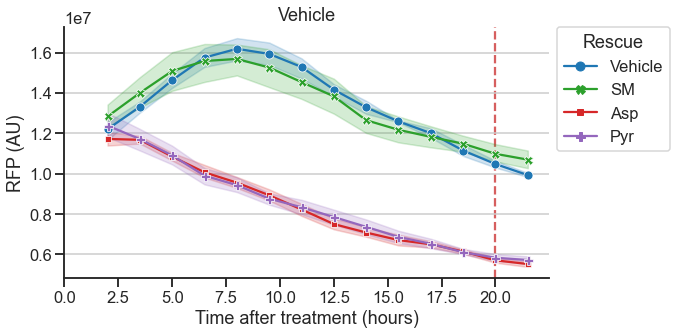

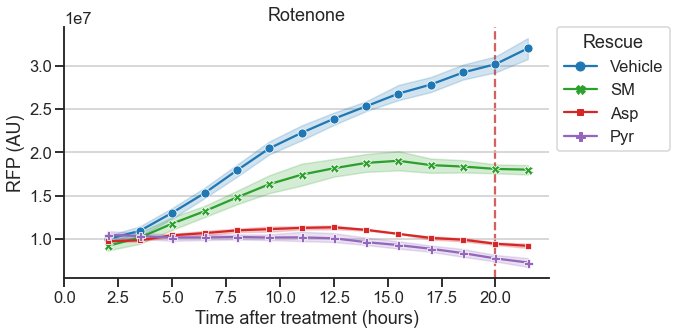

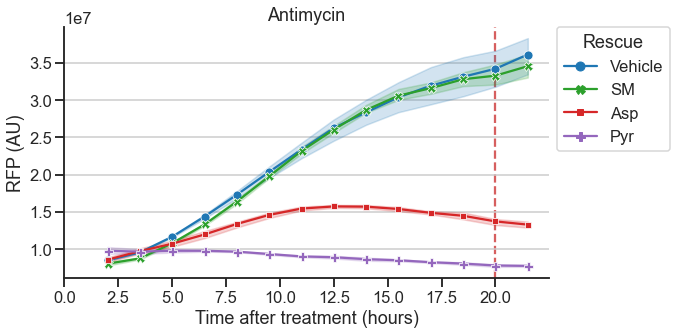

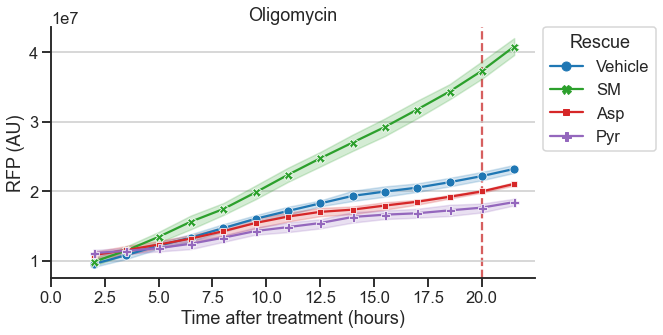

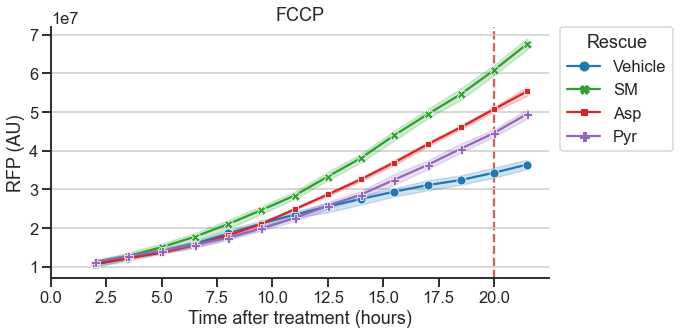

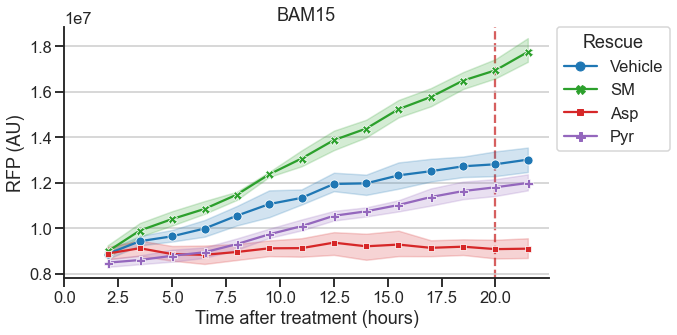

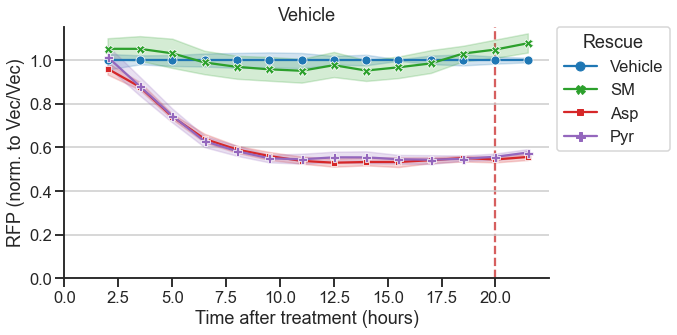

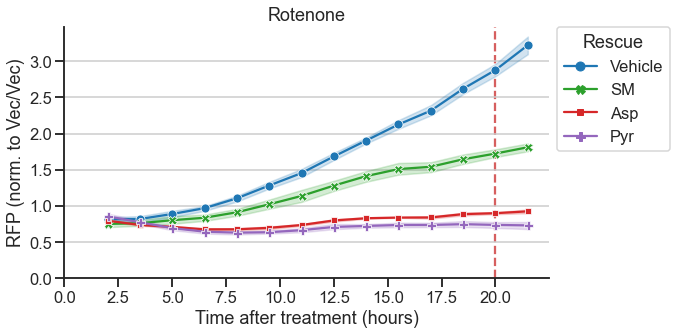

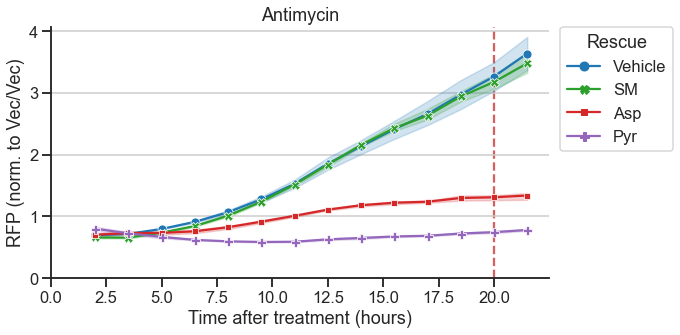

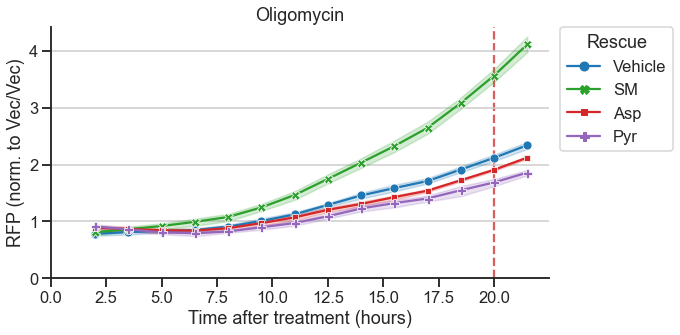

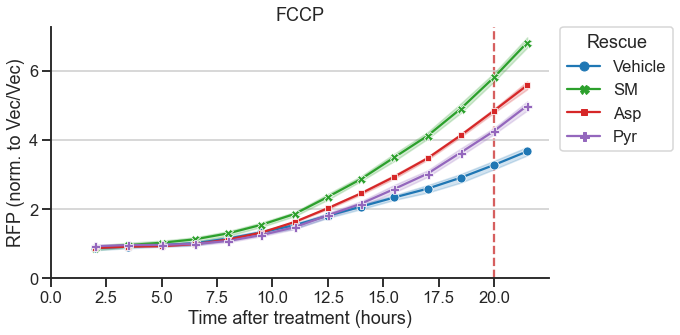

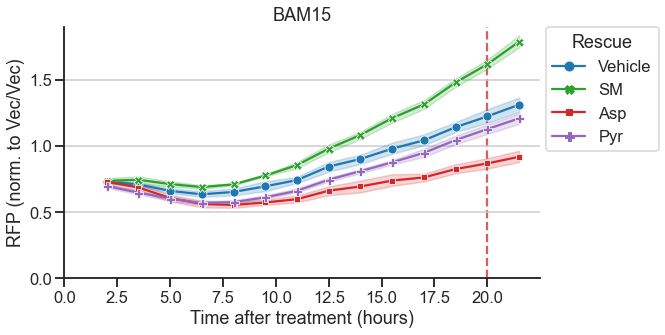

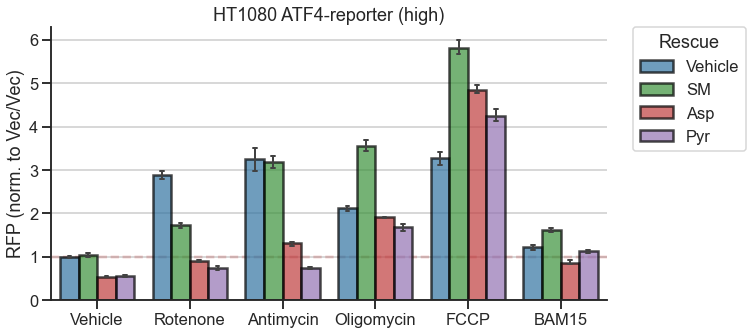

In [12]:
### Plot RFP timecourse - 01-04-22 ###
folder = '01-04-22_high'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'BAM15']
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title)

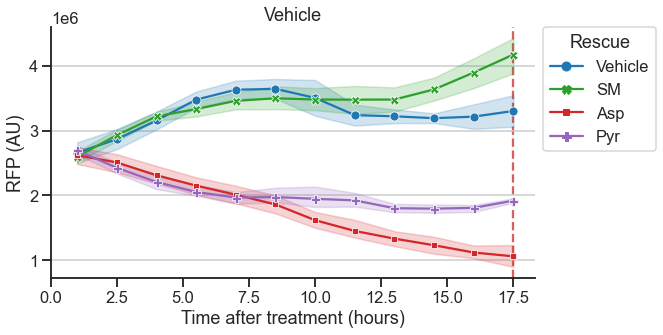

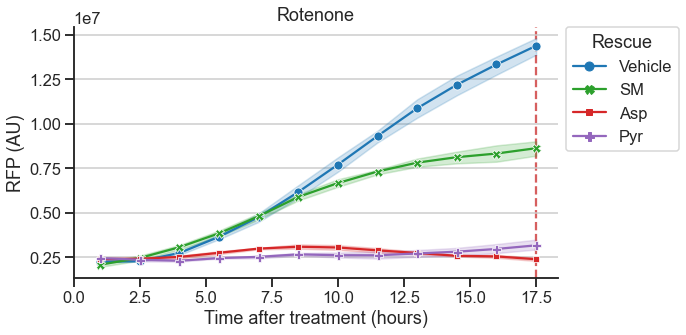

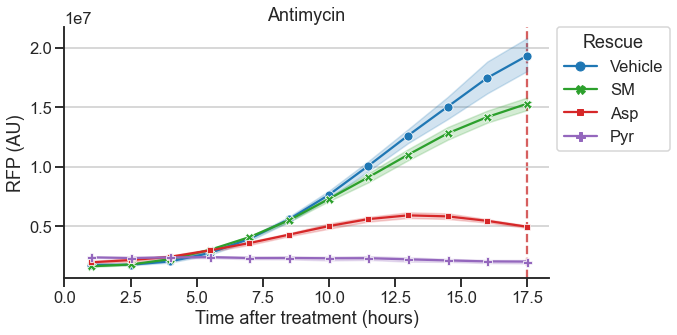

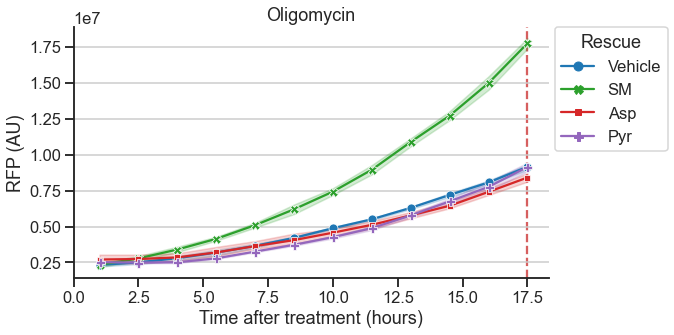

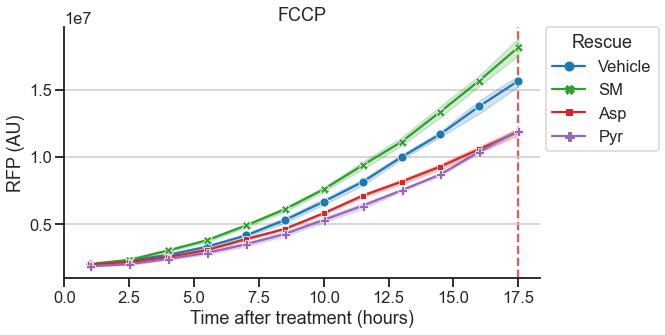

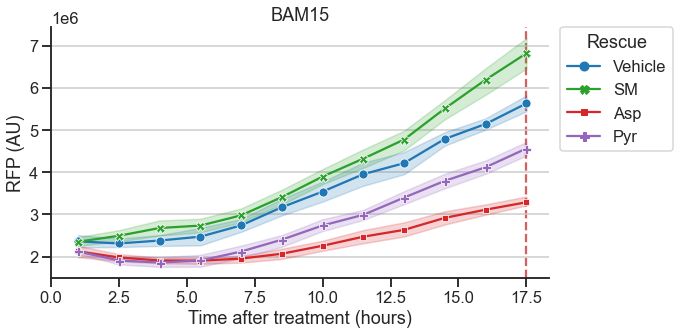

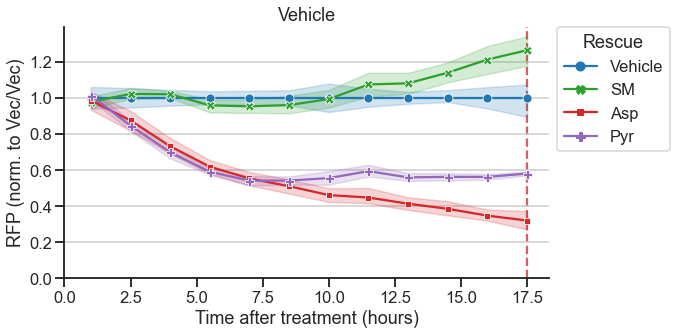

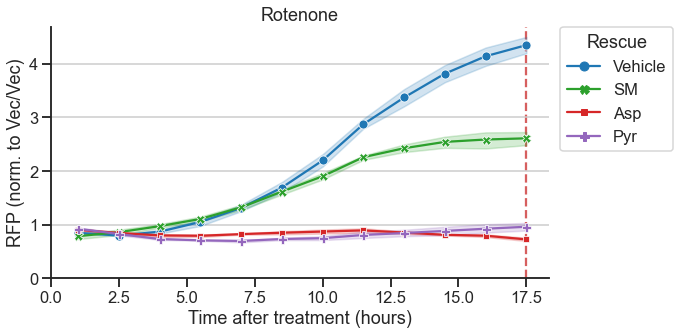

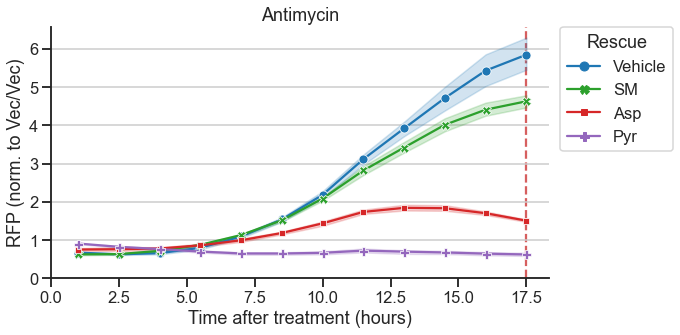

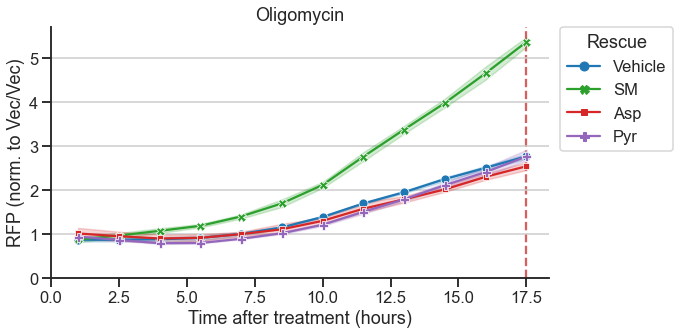

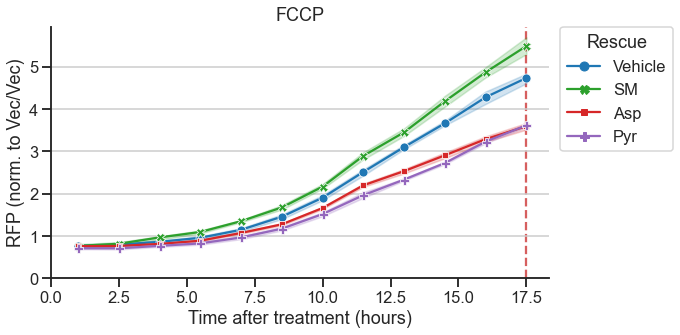

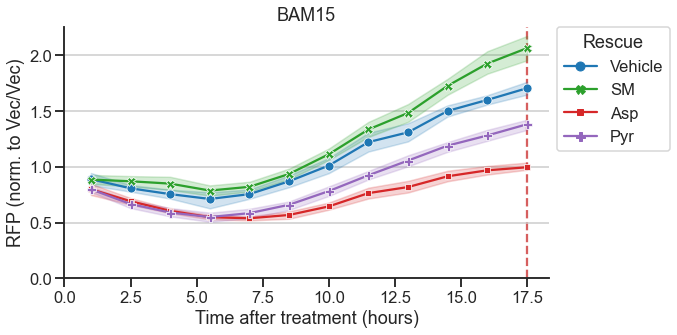

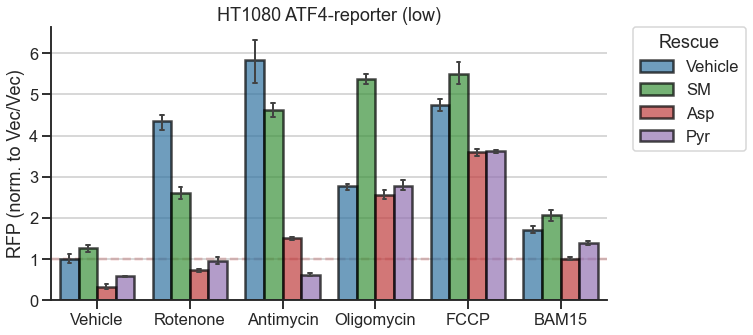

In [13]:
### Plot RFP timecourse - 01-05-22 ###
folder = '01-05-22_low'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'BAM15']
red = {'NoMix': 17.5, 'Mix': 17.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)

# Process HT1080 data from 01-06-22 and 01-07-22

In [14]:
### Process HT1080 data from 01-06-22 and 01-07-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-06-22', '01-07-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080/01-0Xv2-22'

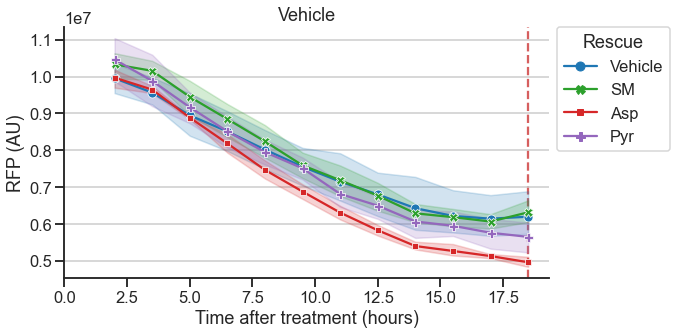

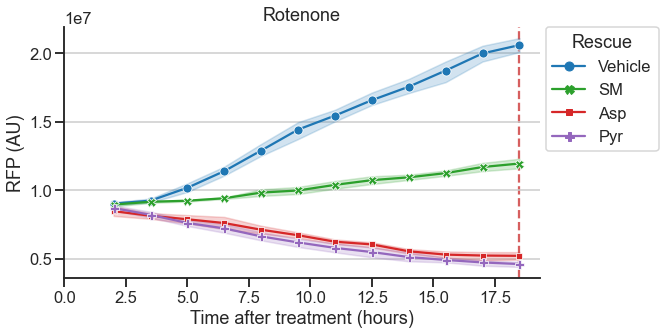

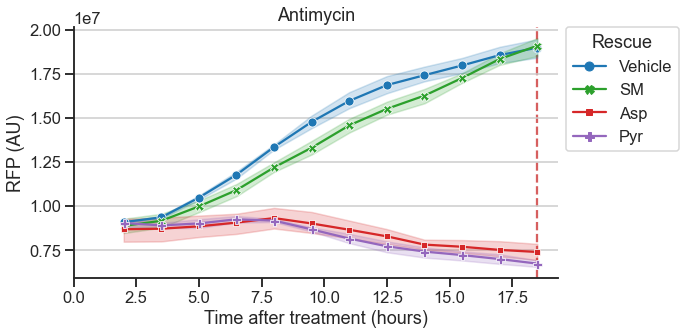

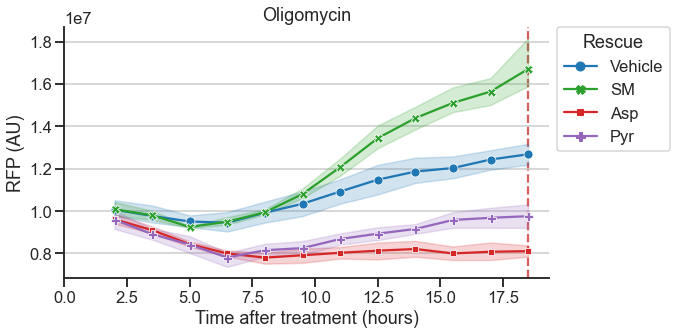

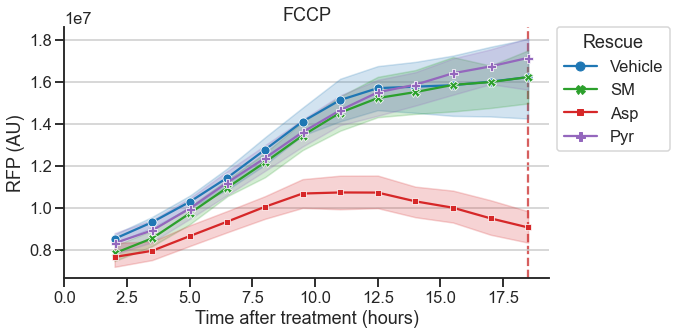

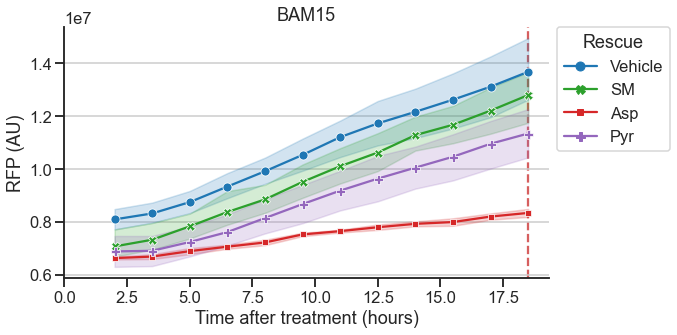

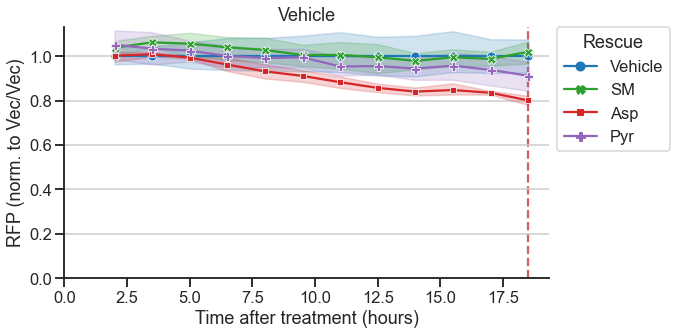

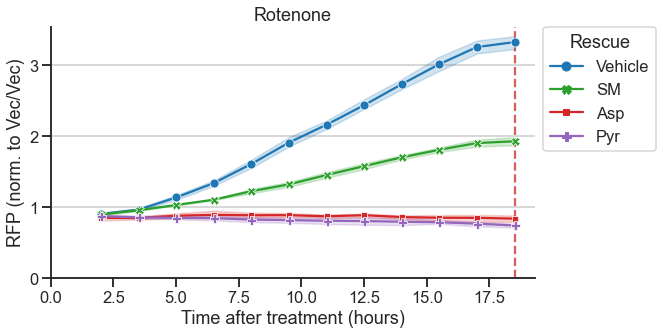

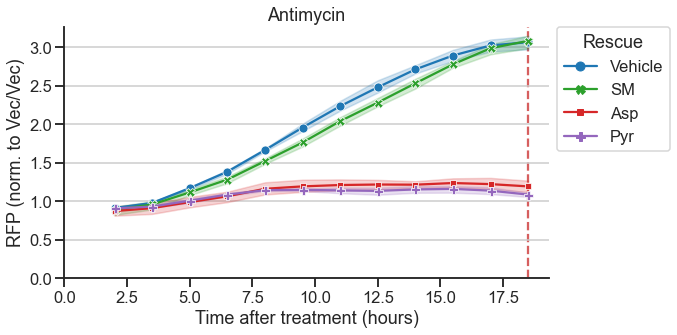

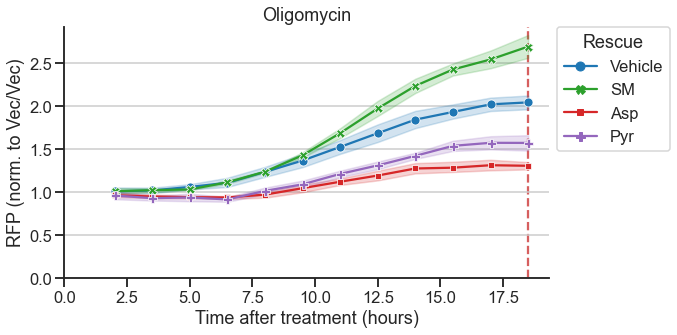

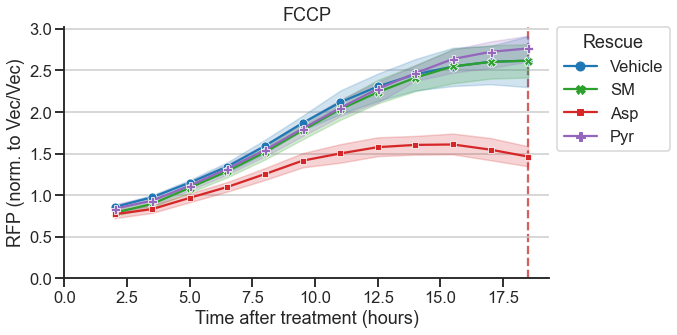

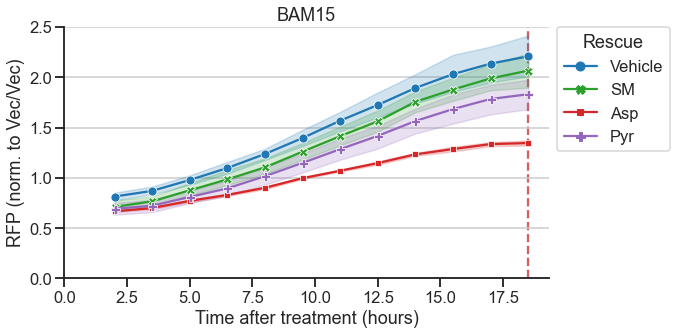

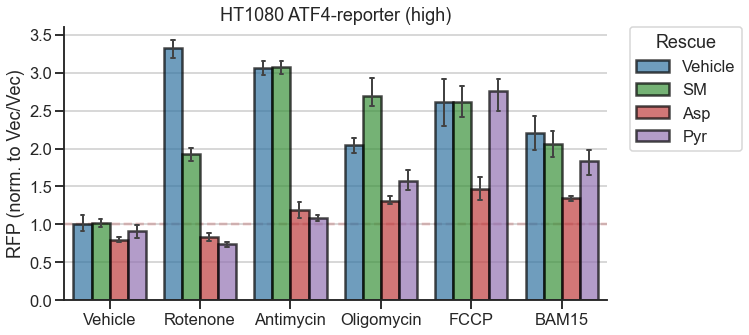

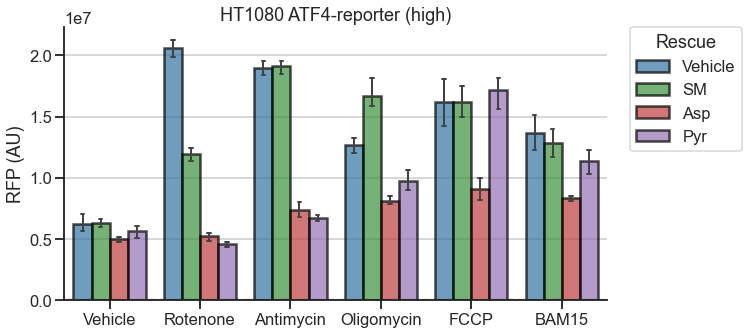

In [15]:
### Plot RFP timecourse - 01-06-22 ###
folder = '01-06-22_high'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'BAM15']
red = {'NoMix': 18.5, 'Mix': 18.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
# Don't use "RFP_norm-VecPlate" for normalization
# because the two last columns will mess it up:
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title, '_norm')
norm = 'RFP'
plot_bars(data, folder, red['NoMix'], norm, title)

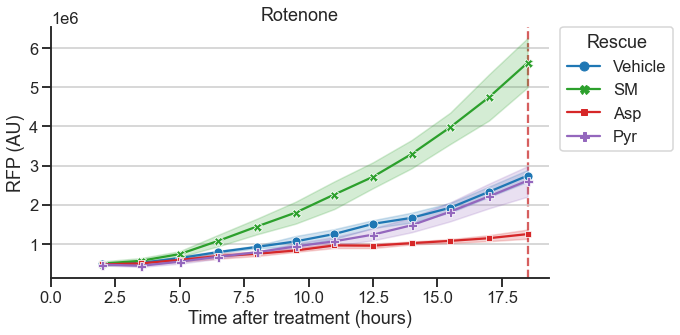

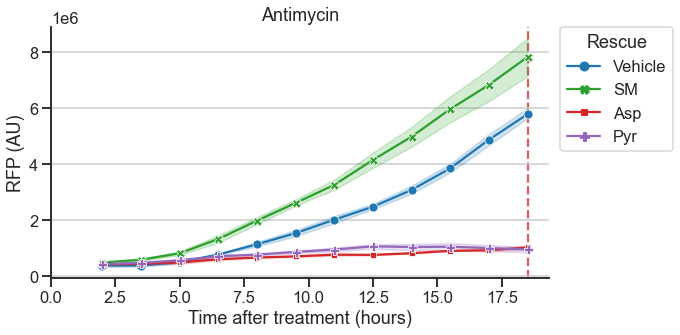

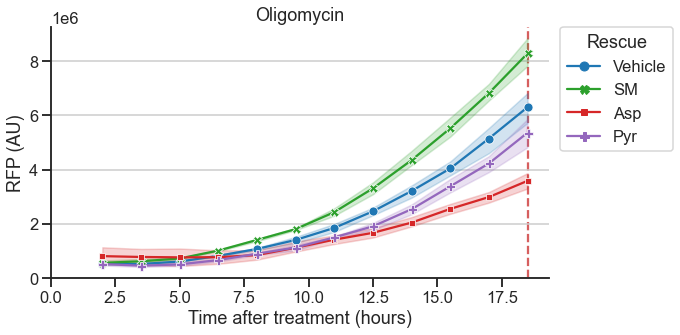

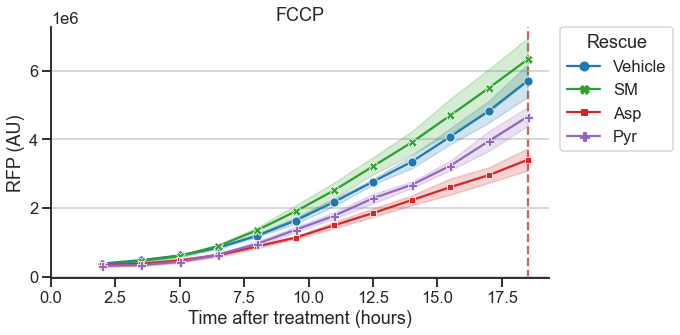

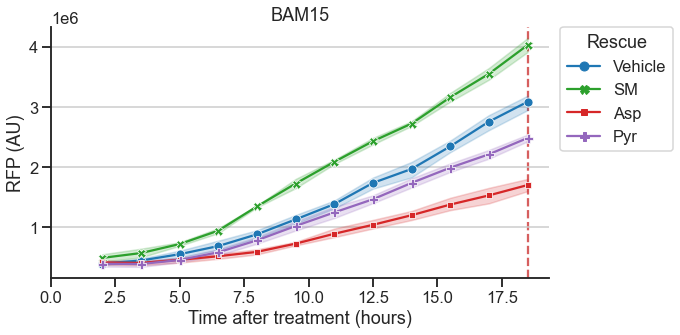

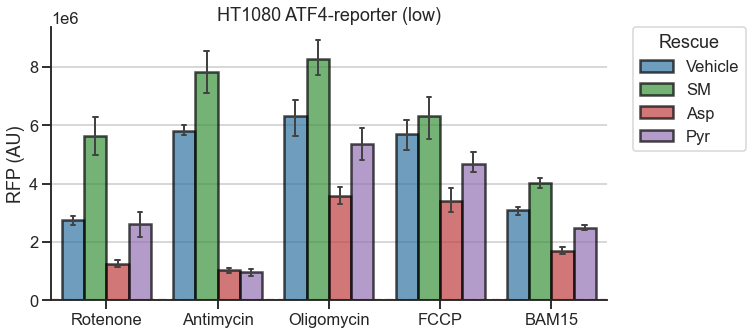

In [16]:
### Plot RFP timecourse - 01-07-22 ###
# Don't have Vehicle plate for this batch #
folder = '01-07-22_low'
drug_list = ['Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'BAM15']
red = {'NoMix': 18.5, 'Mix': 18.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)

# Process HT1080 data from 01-10-22 and 01-11-22

In [17]:
### Process HT1080 data from 01-10-22 and 01-11-22 ###
# These plates only have a single endpoint read #
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-10-22', '01-11-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080/01-1X-22'

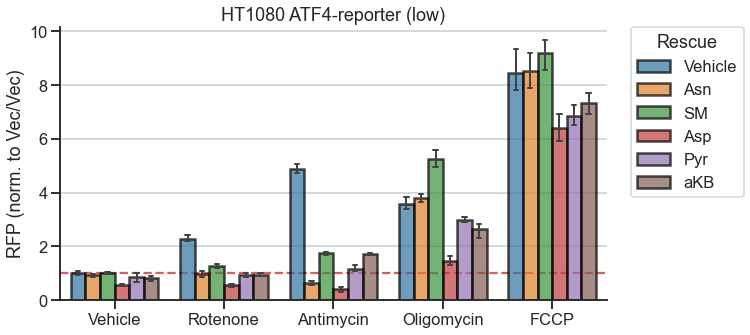

In [18]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '01-11-22_low'
red = {'NoMix': 17, 'Mix': 17}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)

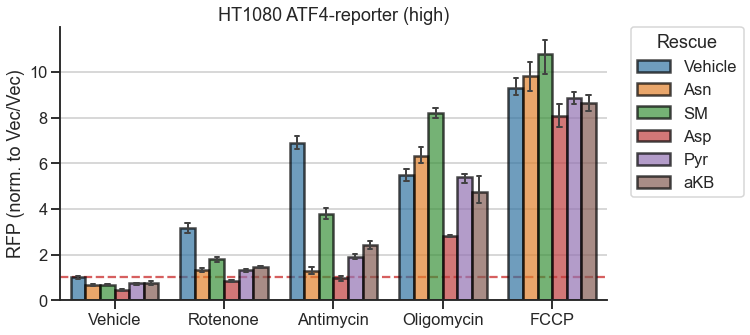

In [19]:
### Plot mito inhibitors for HT1080 ATF4-rep (high) ###
folder = '01-10-22_high'
red = {'NoMix': 17, 'Mix': 17}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title)

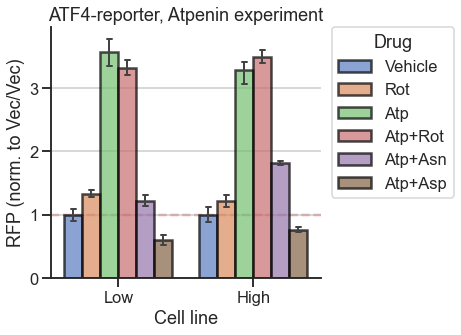

In [20]:
### Plot Atpenin data - 01-2X-22 ###
fd = {'low': '01-11-22_low', 'high': '01-10-22_high'}
td = {'low': 17, 'high': 17}
plot_bar_Atp(data, fd, td, norm, plot_dst)

# Process HT1080 data from 01-13-22

In [21]:
### Process HT1080 data from 01-13-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-13-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080/01-1X-22'

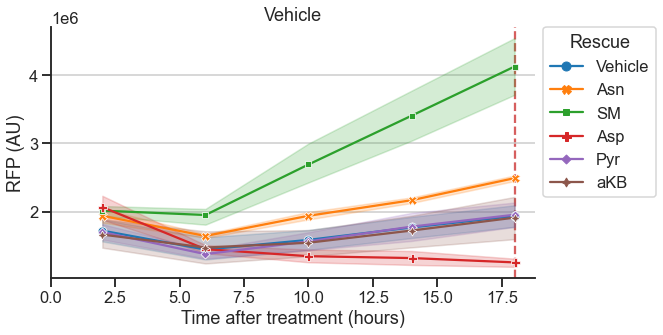

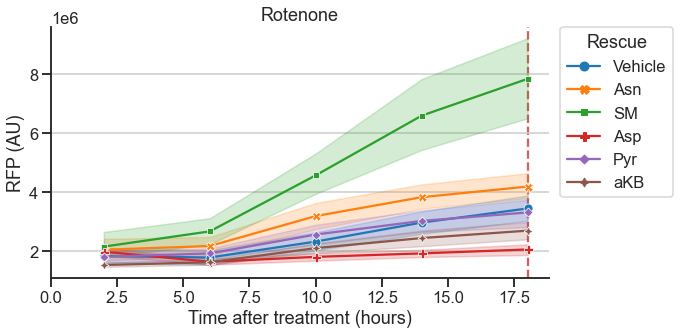

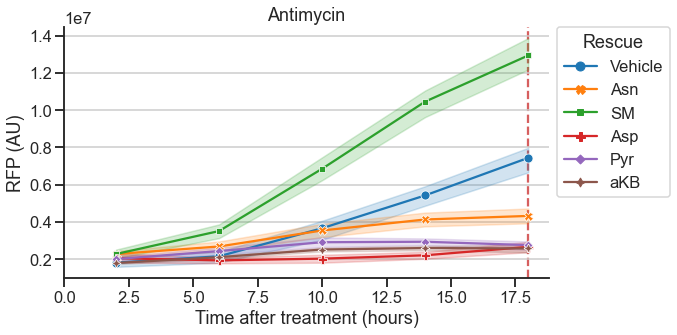

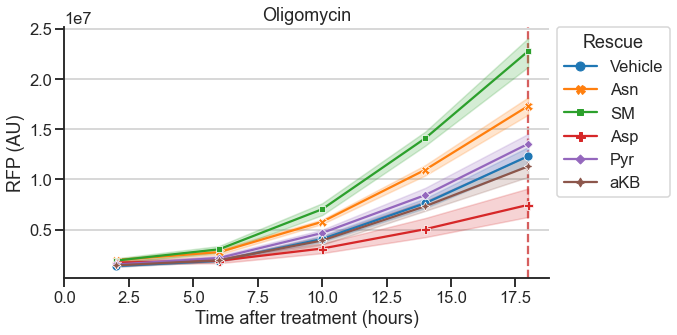

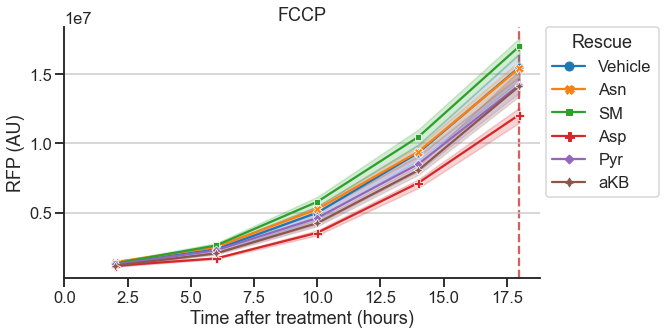

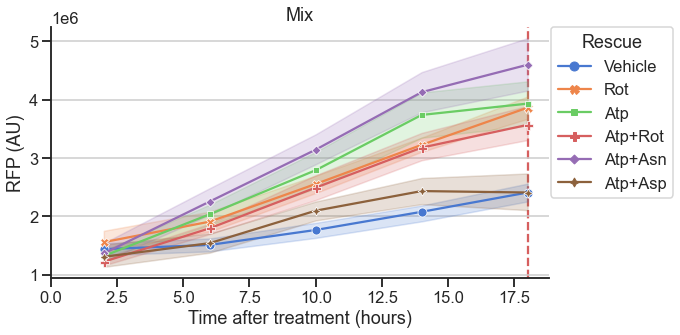

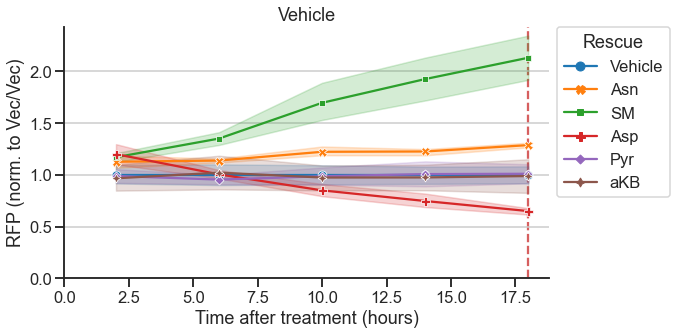

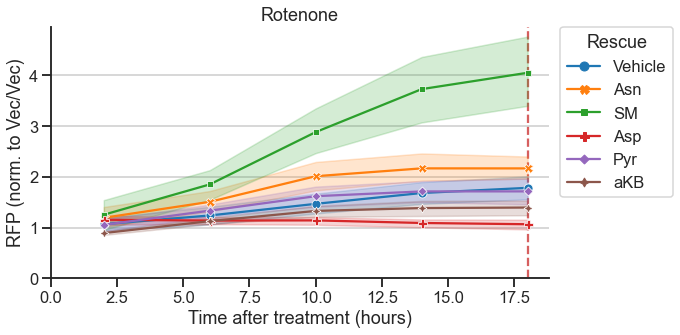

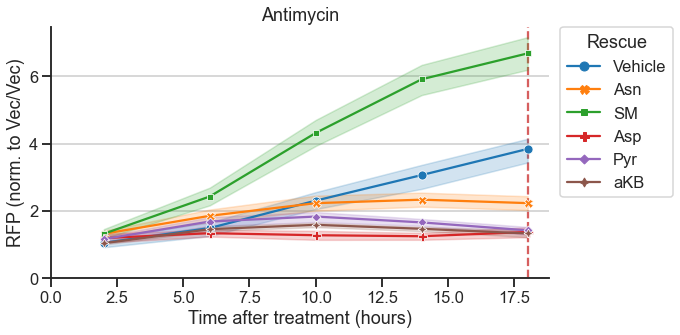

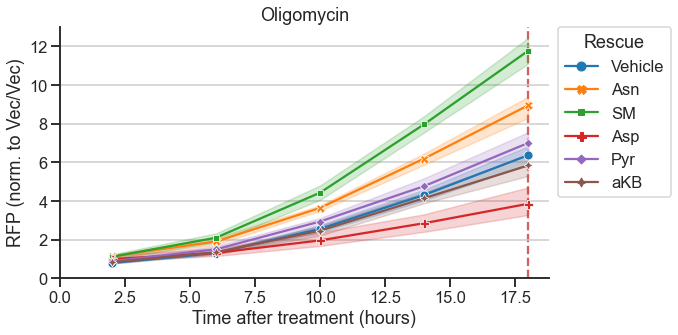

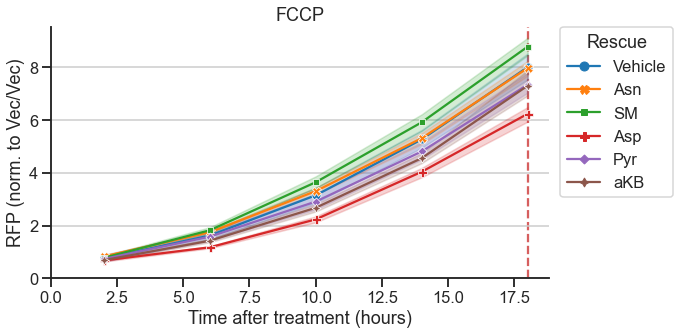

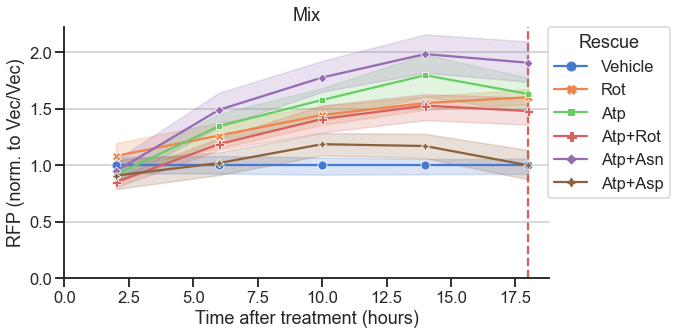

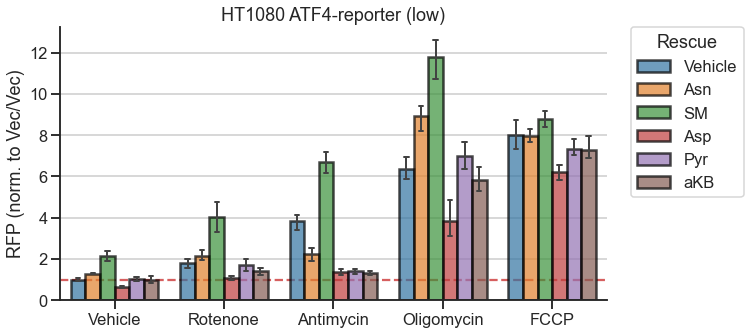

In [22]:
### Plot RFP timecourse - 01-13-22 ###
folder = '01-13-22_low'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 18, 'Mix': 18}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)

# Process 143B data from 01-24-22 and 01-26-22

In [11]:
### Process 143B data from 01-24-22 and 01-26-22 ###
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['01-24-22', '01-26-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/143B/01-2X-22'

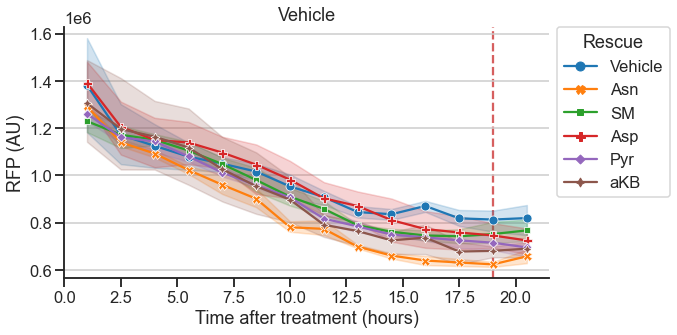

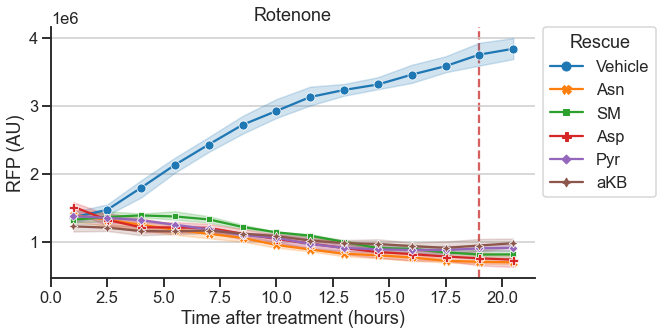

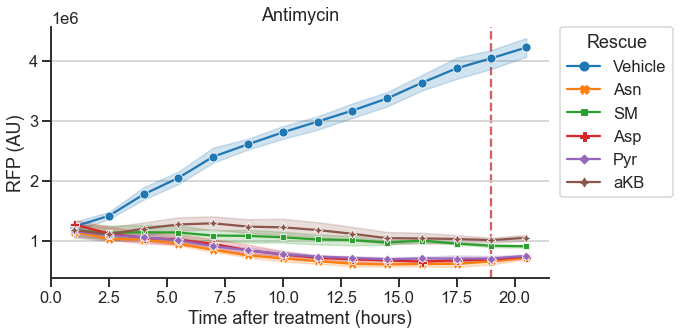

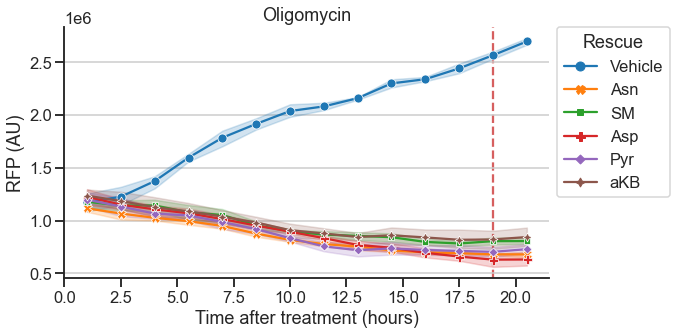

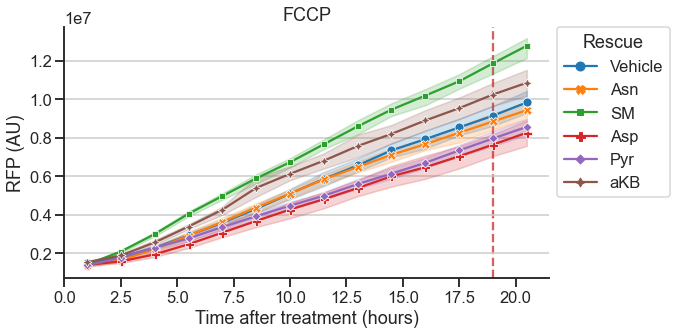

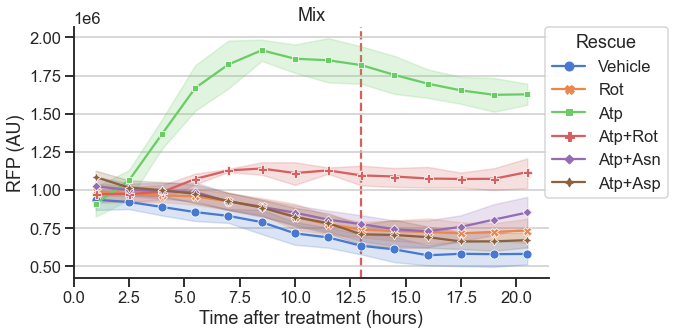

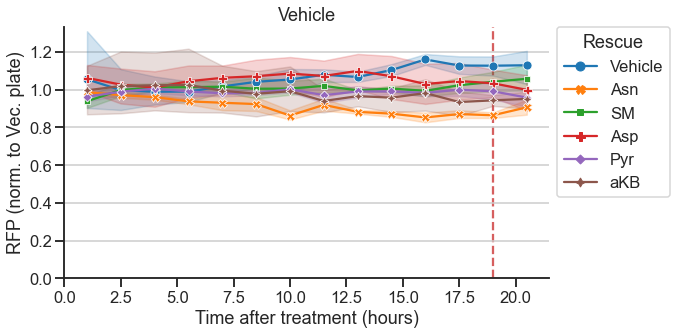

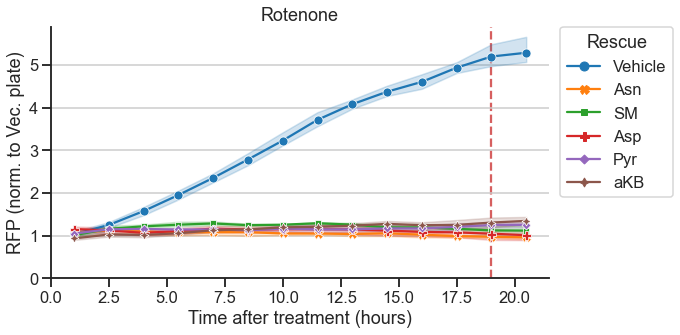

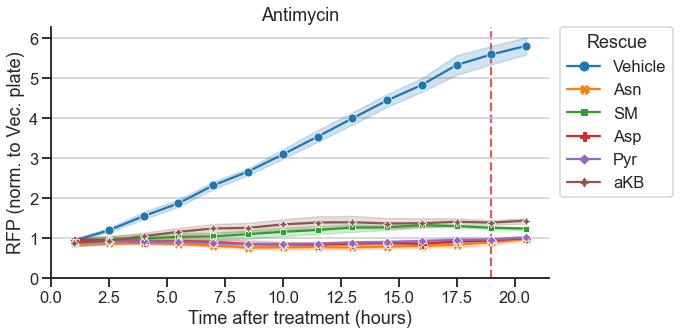

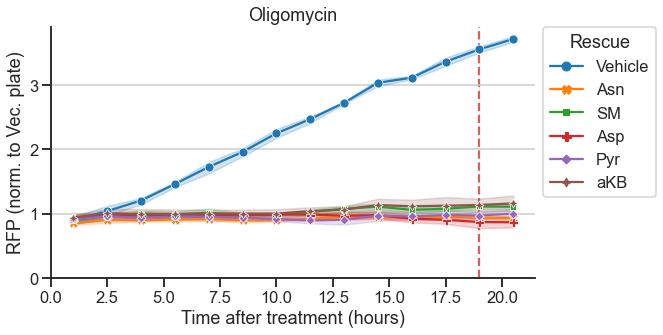

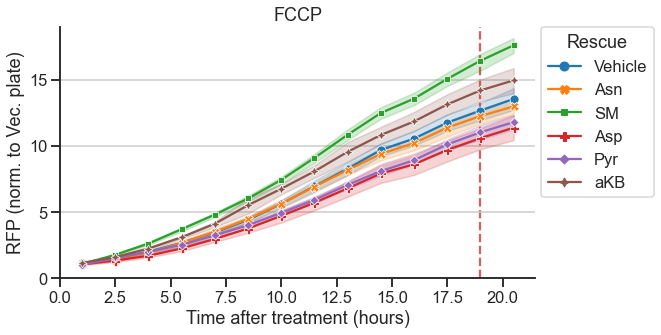

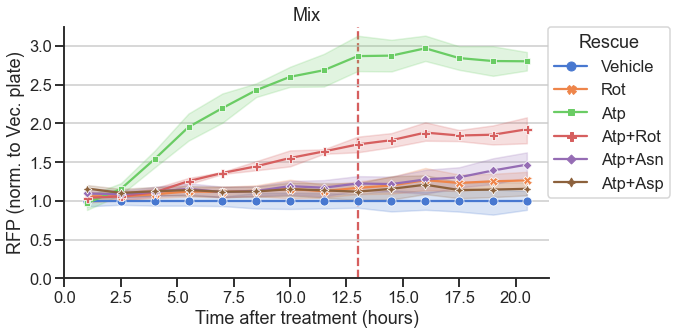

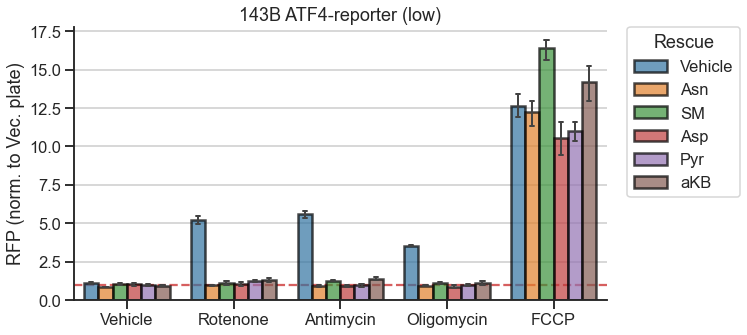

In [24]:
### Plot RFP timecourse - 01-24-22 ###
folder = '01-24-22_low'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 19, 'Mix': 13}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-VecPlate'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = '143B ATF4-reporter (low)'
plot_bars(data, folder, red['NoMix'], norm, title)

In [23]:
def plot_timecourse2(data, folder, drug_list, red, plot_dst, norm):
    for drug in drug_list:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        mask = (data['Folder'] == folder) & (data['Drug'] == drug) & (data['Rescue'] != 'NA1') & (data['Rescue'] != 'NA2') & (data['Rescue'] != 'SM') & (data['Rescue'] != 'aKB')
        if drug != 'Mix':
            hue_list = ['Vehicle', 'Asn', 'SM', 'Asp', 'Pyr', 'aKB']
            hue_obs = list(set(data[mask]['Rescue'].values))
            hue_order = sorted(hue_obs, key=lambda x: hue_list.index(x))
            hue2col = {hue: palette[i] for i, hue in enumerate(hue_list)}
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', hue_order=hue_order, palette=hue2col, ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
        else:
            g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y=norm, hue='Rescue', ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
        ax1.set_xlim(0, ax1.get_xlim()[1])
        if norm != 'RFP':
            ax1.set_ylim(0, ax1.get_ylim()[1])
        g1.set_ylabel('ATF4 reporter')
        g1.set_xlabel('Time after treatment (hours)')
        g1.set_title('{}'.format(drug))
        g1.grid(True, axis='y')
        g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')
        sns.despine()
        fig.tight_layout()
        if norm == 'RFP':
            fig.savefig('{}/{}_{}-timecourse_FNT.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')
        else:
            fig.savefig('{}/{}_{}-timecourse_norm_FNT.pdf'.format(plot_dst, folder, drug), bbox_inches='tight')

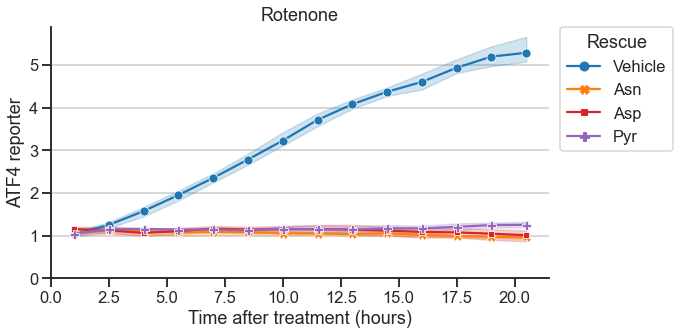

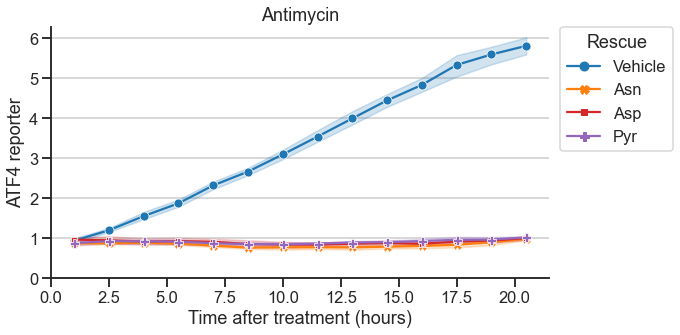

In [24]:
### Plot RFP timecourse - 01-24-22 ###
folder = '01-24-22_low'
drug_list = ['Rotenone', 'Antimycin']
red = {'NoMix': 19, 'Mix': 13}
norm = 'RFP_norm-VecPlate'
plot_timecourse2(data, folder, drug_list, red, plot_dst, norm)

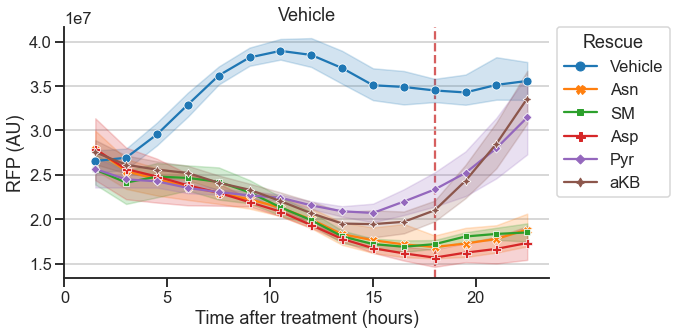

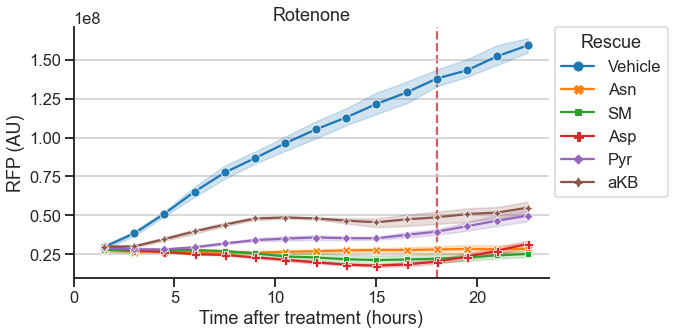

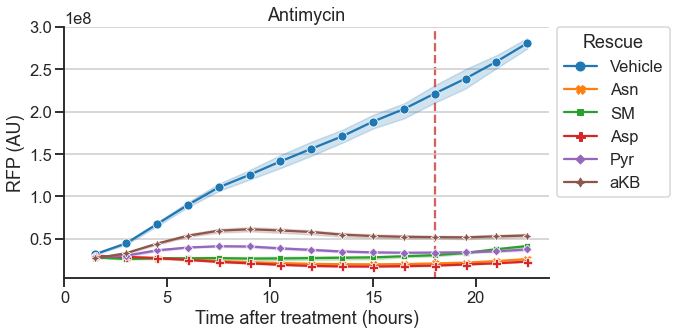

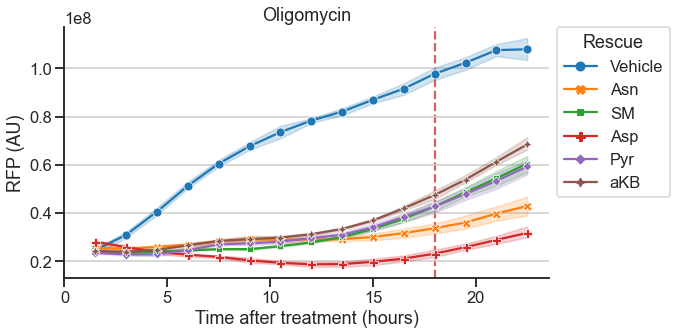

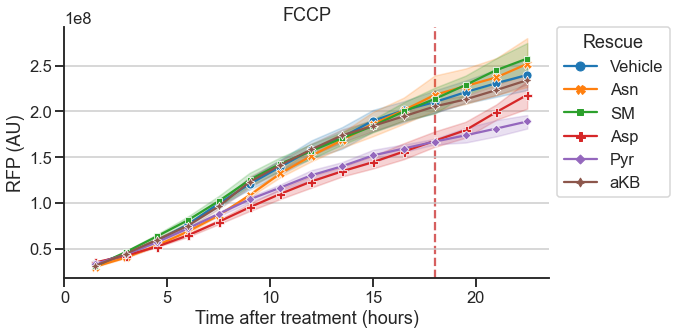

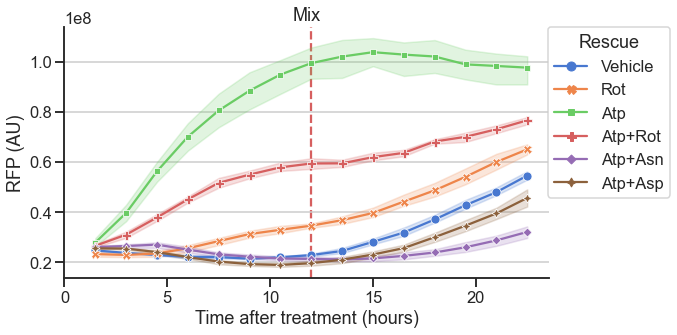

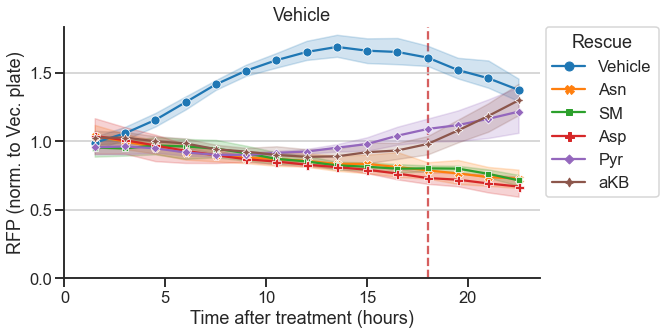

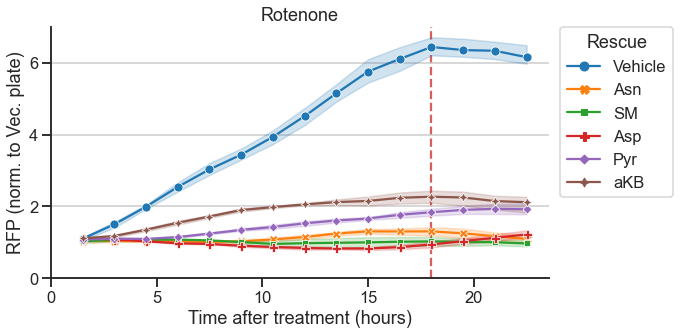

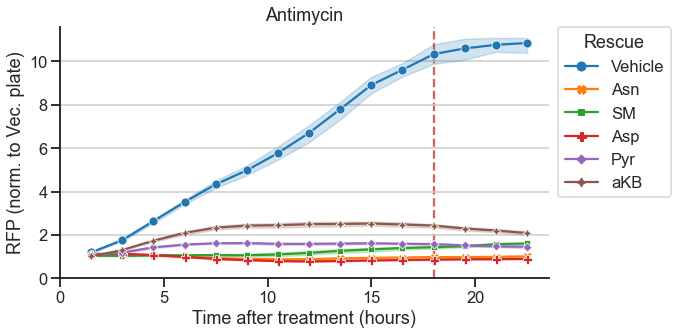

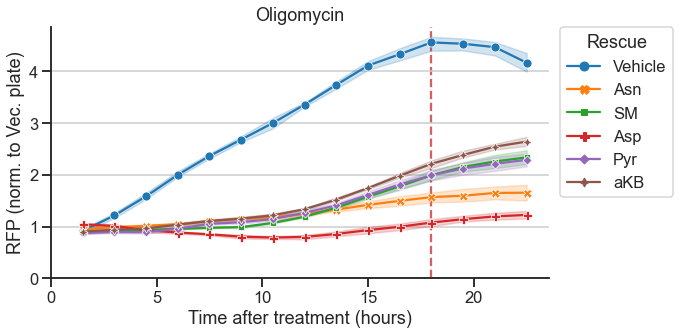

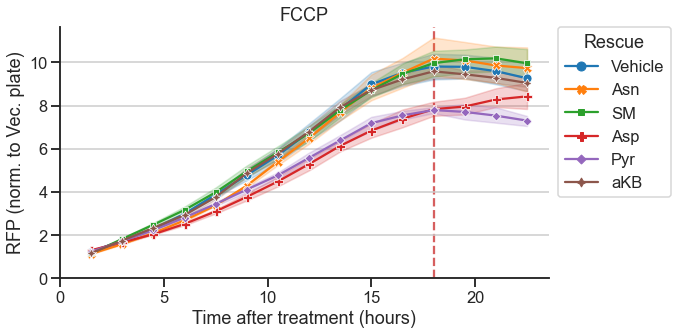

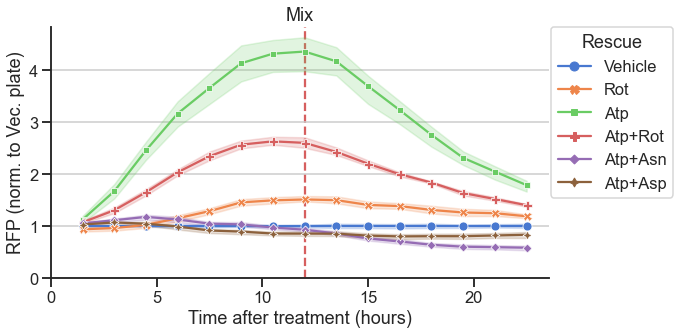

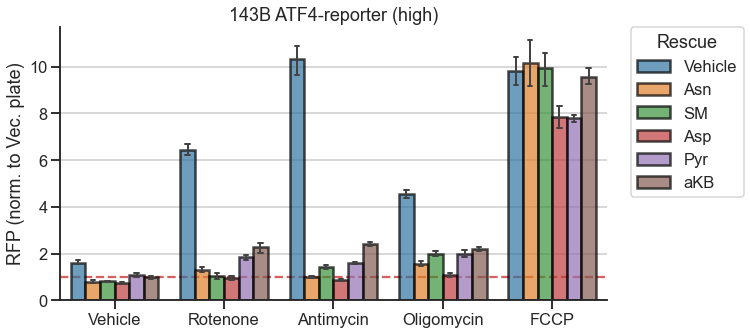

In [25]:
### Plot RFP timecourse - 01-26-22 ###
folder = '01-26-22_high'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 18, 'Mix': 12}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-VecPlate'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = '143B ATF4-reporter (high)'
plot_bars(data, folder, red['NoMix'], norm, title)

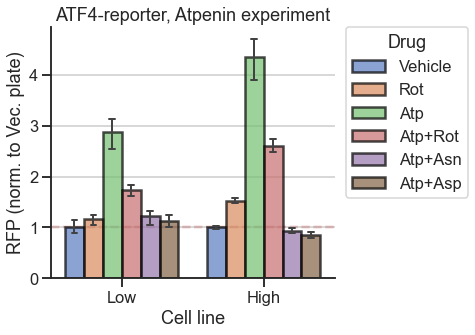

In [26]:
### Plot Atpenin data - 01-2X-22 ###
fd = {'low': '01-24-22_low', 'high': '01-26-22_high'}
td = {'low': 13, 'high': 12}
plot_bar_Atp(data, fd, td, norm, plot_dst)

# Process HT1080 HRI KO pool data from 02-04-22

In [27]:
### Process data ###
cell_line_folder = 'HT1080-WT_ATF4-rep_HRI-KO-pool'
date_list = ['02-04-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080-pooled-KO/02-04-22_HRI'

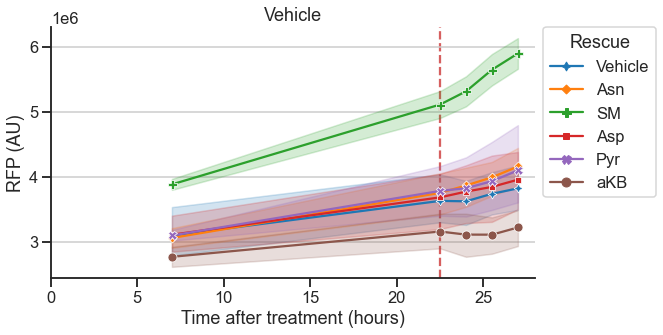

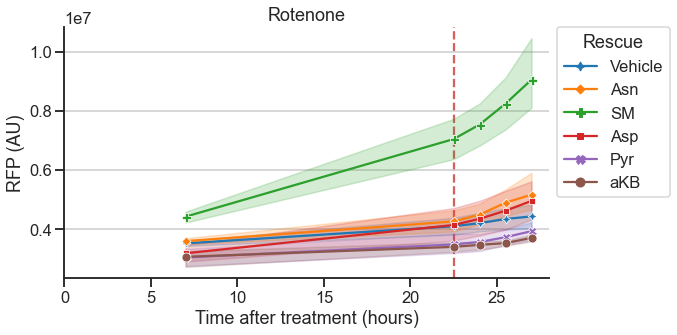

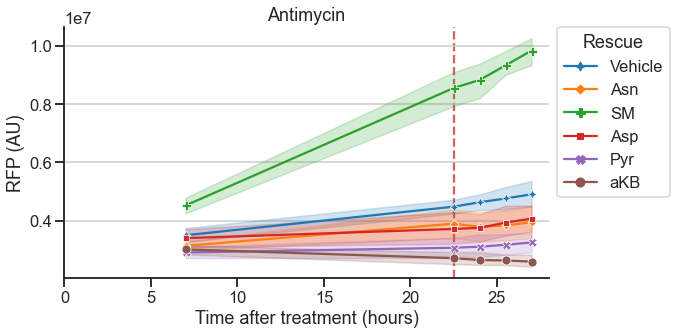

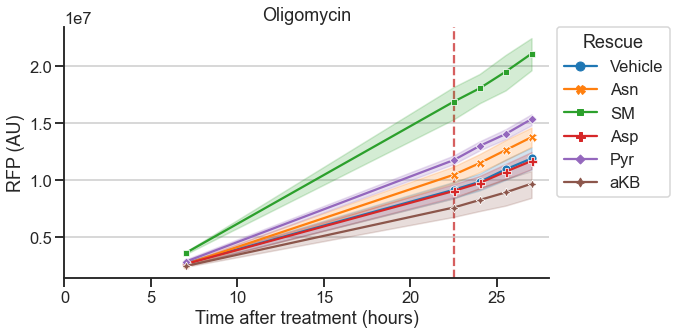

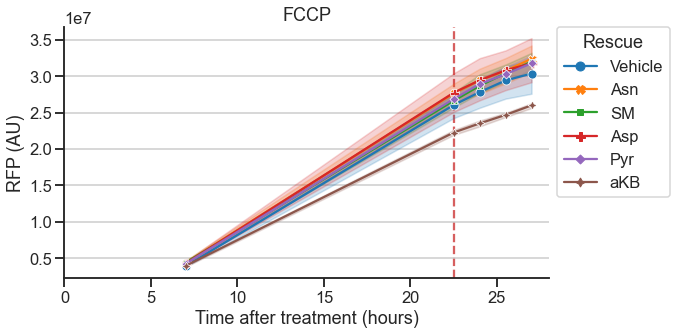

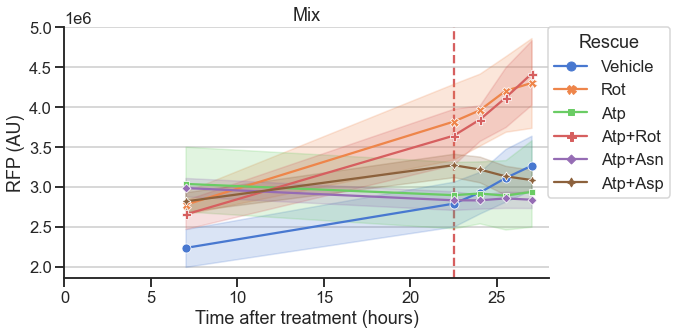

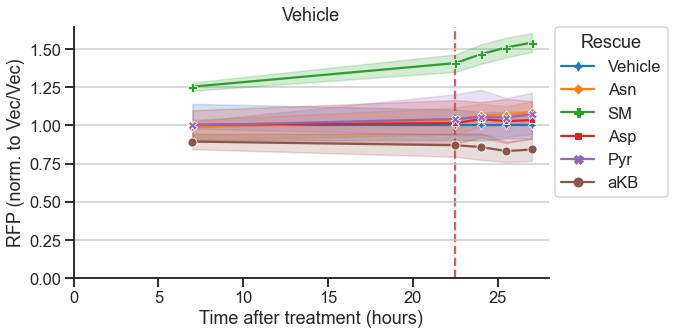

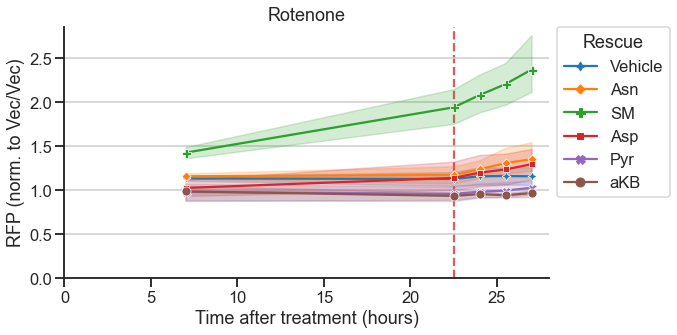

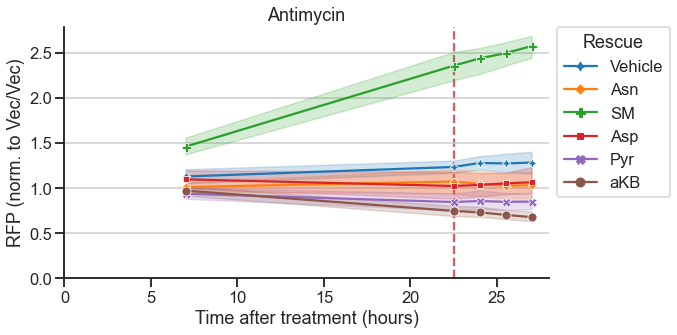

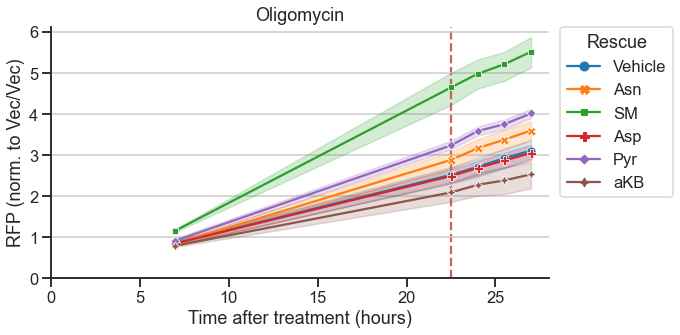

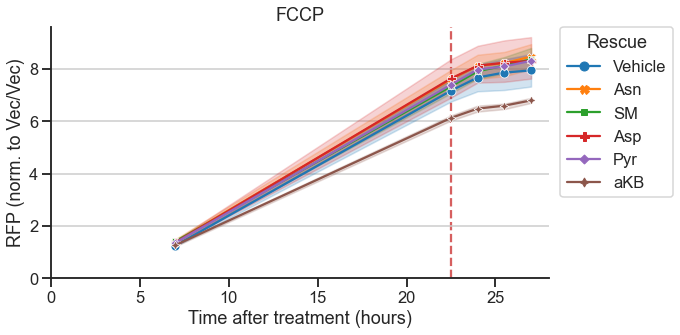

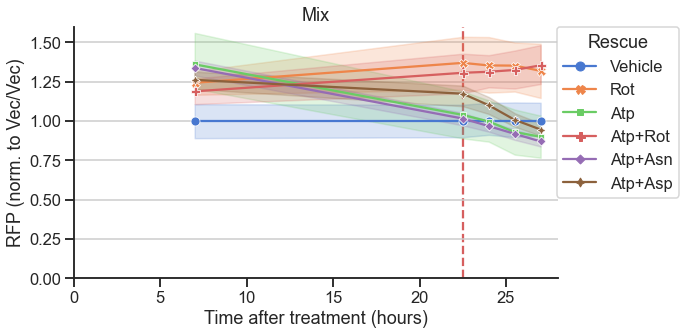

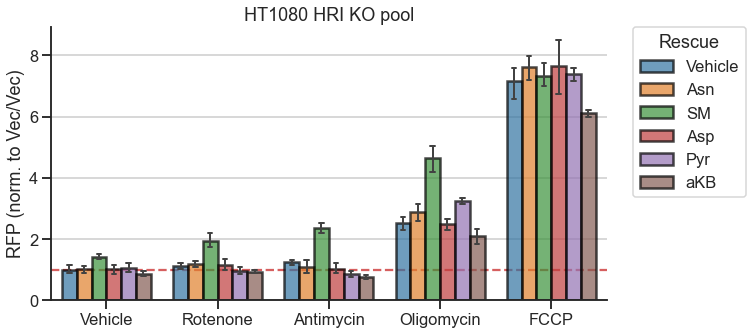

In [28]:
### Plot RFP timecourse ###
folder = '02-04-22_low-HRI'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 22.5, 'Mix': 22.5}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 HRI KO pool'
plot_bars(data, folder, red['NoMix'], norm, title)

# Process HT1080 OMA1 KO pool data from 02-04-22

In [29]:
### Process data ###
cell_line_folder = 'HT1080-WT_ATF4-rep_OMA1-KO-pool'
date_list = ['02-04-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080-pooled-KO/02-04-22_OMA1'

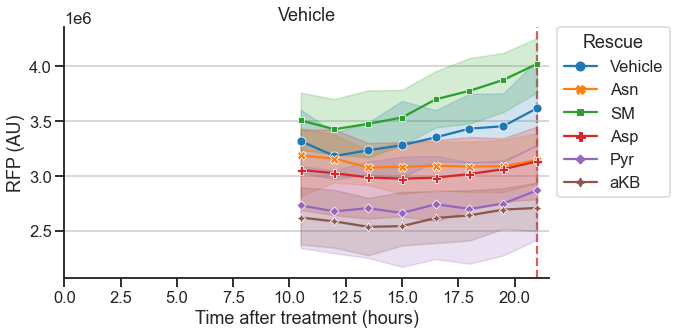

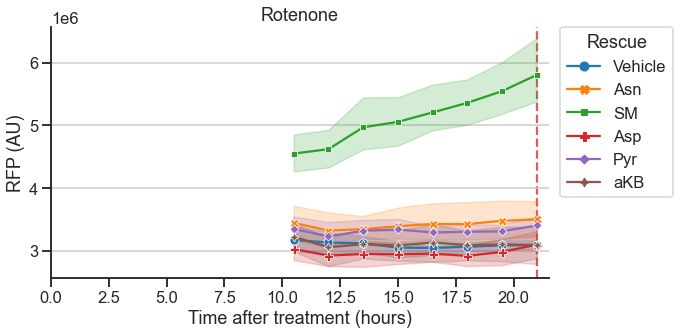

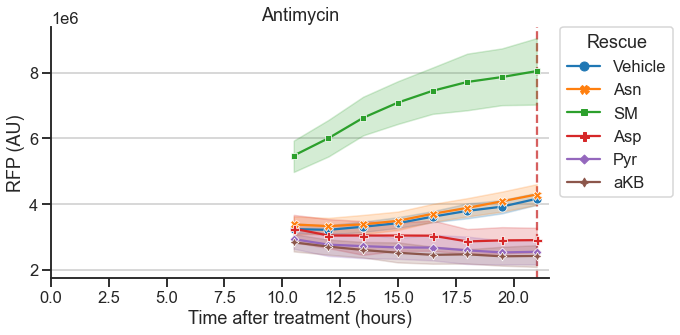

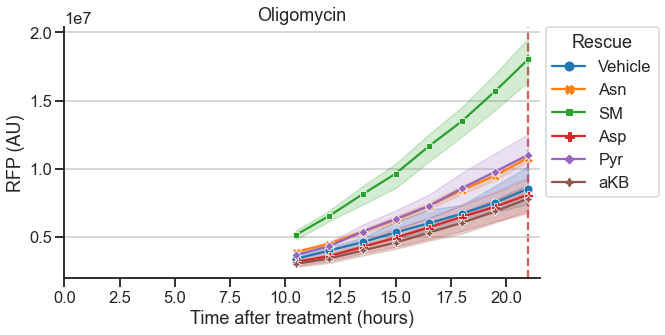

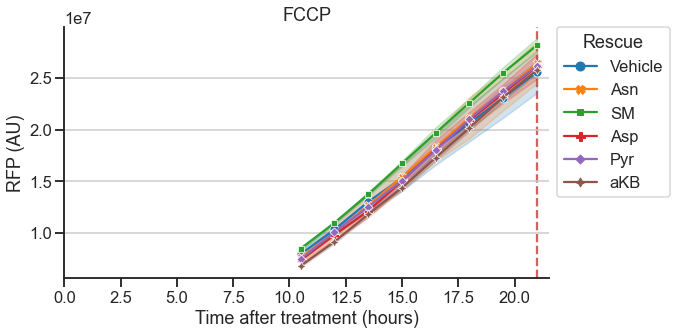

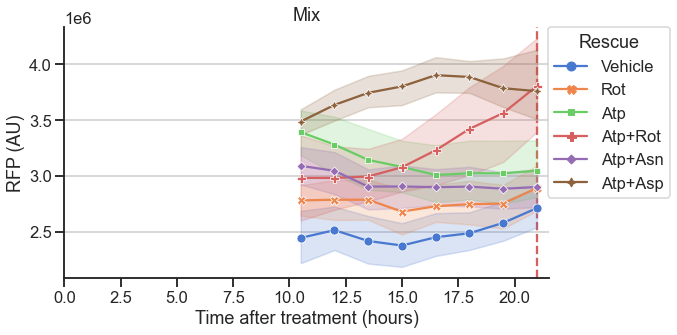

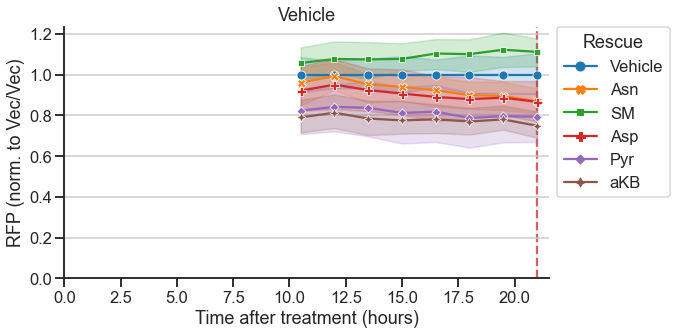

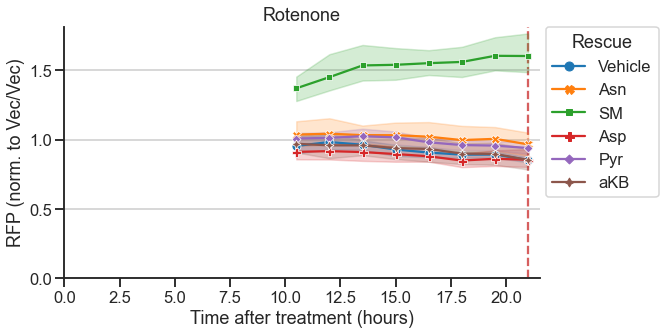

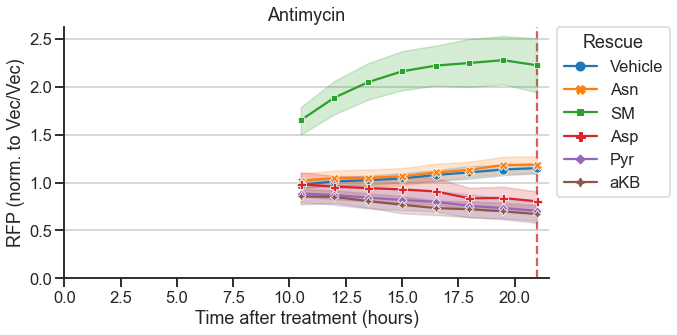

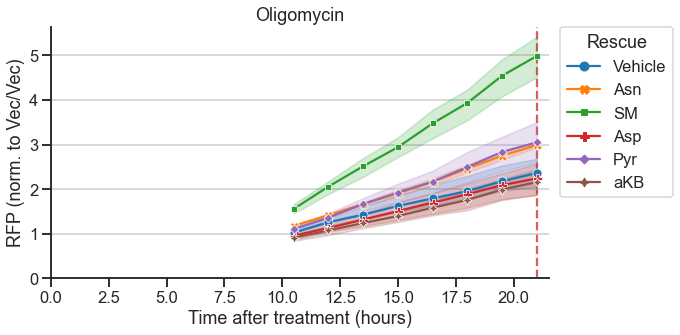

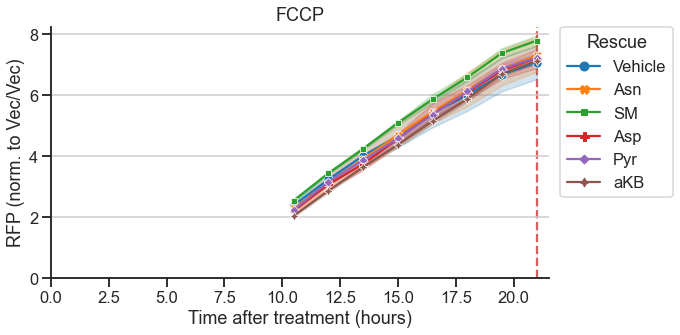

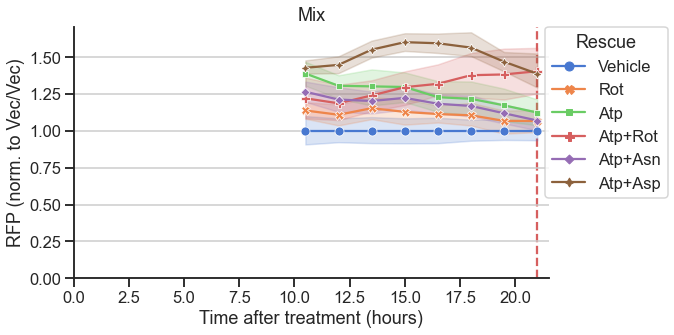

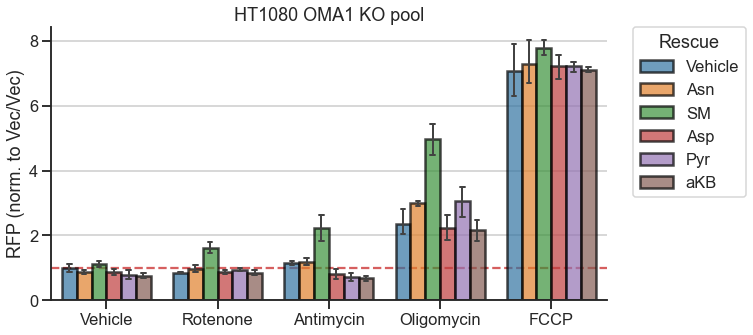

In [30]:
### Plot RFP timecourse ###
folder = '02-04-22_low-OMA1'
drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP', 'Mix']
red = {'NoMix': 21, 'Mix': 21}
norm = 'RFP'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
norm = 'RFP_norm-Vec-Vec'
plot_timecourse(data, folder, drug_list, red, plot_dst, norm)
title = 'HT1080 OMA1 KO pool'
plot_bars(data, folder, red['NoMix'], norm, title)

# Process HT1080 eGFP data from 02-15-22

In [26]:
### Process data ###
# These plates only have a single endpoint read #
# Cells were fixed and data quality here is suboptimal #
cell_line_folder = 'HT1080-WT_ATF4-rep_eGFP'
date_list = ['02-15-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_eGFP'

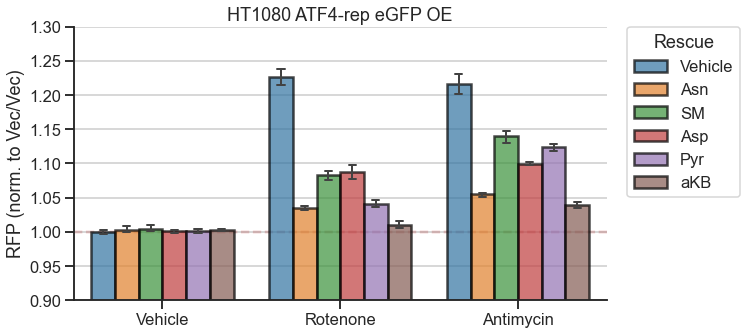

In [27]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '02-15-22_low-eGFP-mean'
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep eGFP OE'
plot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)

# Process HT1080 ASNS data from 02-15-22

In [28]:
### Process data ###
# These plates only have a single endpoint read #
# Cells were fixed and data quality here is suboptimal #
cell_line_folder = 'HT1080-WT_ATF4-rep_ASNS'
date_list = ['02-15-22']
data = rp_data(cell_line_folder, date_list)
plot_dst = 'plots/HT1080-eGFP-ASNS/02-15-22_ASNS'

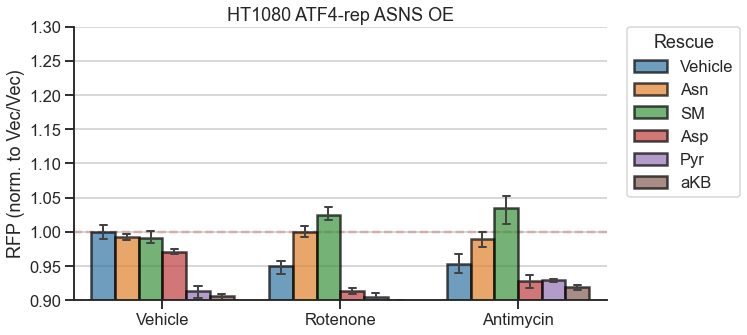

In [29]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###
folder = '02-15-22_low-ASNS-mean'
red = {'NoMix': 20, 'Mix': 20}
norm = 'RFP_norm-Vec-Vec'
title = 'HT1080 ATF4-rep ASNS OE'
plot_bars(data, folder, red['NoMix'], norm, title, y0=0.90, y1=1.3)

# Process HT1080 GOT DKO data from 02-01-22

In [ ]:
# To be done

# Process 143B data from 02-02-22 and 02-03-22

In [30]:
# To be done